 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 7. Neural Network Improvements**
# Section 6. Regularization (2) Dropout

### _Objective_
1. 딥러닝에서 많이 이용하는 정규화 방법 중 하나인 Dropout에 대해 배워보도록 하겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [2]:
%matplotlib inline
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import os
import time
from tqdm import tqdm

np.random.seed(30)
tf.random.set_random_seed(30)

# Tensorboard 추가하기
!pip install tensorboardcolab
import tensorboardcolab

LOG_DIR = "./logs/" # Tensorboard 로그 폴더 위치
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

tbc = tensorboardcolab.TensorBoardColab(graph_path=LOG_DIR)

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


## 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 데이터셋입니다. <br>
아래와 같이 랜덤으로 50개의 데이터셋을 만들고, Test 데이터셋은 노이즈를 주지 않았습니다.<br>
데이터에 노이즈가 많고, 수가 적을 때 일반적으로 Overfitting이 발생하기 쉽습니다.

In [3]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,30)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 50
test 데이터셋 크기 : 30


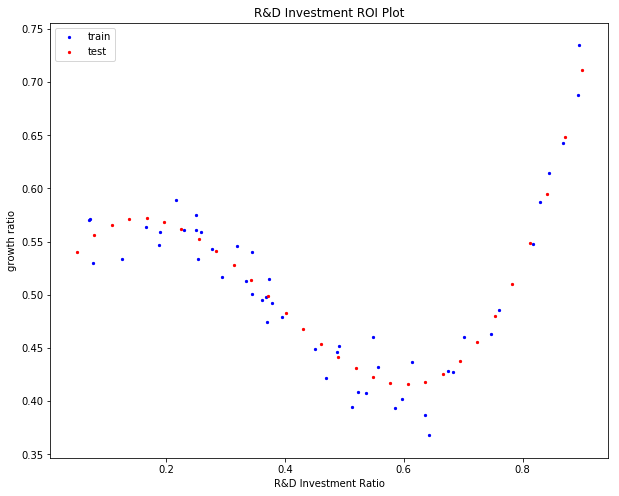

In [4]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,30)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

<br><br>

# \[ 1. 드랍아웃이란? \]

----

----

> *드랍아웃은 매우 간단한 아이디어로, 정규화 효과를 가져다 주는 알고리즘입니다.* <br>

## 1. 드랍아웃 알고리즘
---

![Imgur](https://i.imgur.com/m9diJOx.png)

드랍아웃 알고리즘은 매우 간단합니다. 매 훈련 스텝에서 각 유닛들은 p%확률로 꺼버리게 됩니다.<br>그리고 테스트를 하는 단계에서는 드롭아웃을 적용하지 않습니다.

<br>
## 2. Numpy 코드로 이해하기
---

* 놓치지 말아야할 것중 하나는 바로 훈련하는 동안에 각 뉴런의 출력을 보존 확률($1-p$)로 나누어야 합니다.<br>
* 이를 통해, Test 때의 입력값의 크기와 Train 때의 입력값의 크기가 비슷하도록 만들어 줍니다.<br>

### (1) dropout 레이어 구성하기 

In [5]:
class Dropout:
    def __init__(self, drop_ratio=0.5):
        # Gradient Descent할 때 필요한 값
        self.drop_ratio = drop_ratio
        self.mask = 0
        self.out = 0
        
    def forward(self, X, is_train):
        if is_train is True:
            self.mask = np.random.binomial([np.ones(X.shape)],
                                              1-self.drop_ratio)[0]
            self.out = self.mask * X * (1.0/(1-self.drop_ratio))
        else:
            self.out = X
            
        return self.out
        
    def backward(self, grad):
        return grad * self.mask

### (2) Test 때와 Train 때의 동작 비교

In [6]:
x = np.ones([10,124])
dropout_layer = Dropout(drop_ratio=0.6)

In [7]:
dropout_layer.forward(x,True)

array([[2.5, 2.5, 0. , ..., 0. , 0. , 0. ],
       [2.5, 2.5, 2.5, ..., 2.5, 0. , 2.5],
       [0. , 0. , 0. , ..., 0. , 2.5, 2.5],
       ...,
       [0. , 2.5, 0. , ..., 2.5, 0. , 2.5],
       [0. , 0. , 0. , ..., 0. , 0. , 2.5],
       [0. , 2.5, 0. , ..., 0. , 0. , 0. ]])

In [8]:
dropout_layer.forward(x,False)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

<br>
## 3. Tensorflow에서의 동작 확인하기
---


### (1) Training 때의 동작 확인하기

In [9]:
graph = tf.Graph()
with graph.as_default():
    x = tf.ones([10,124],tf.float32)
    is_train = tf.constant(True)
    y = tf.layers.Dropout(0.6)(x,training=is_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
sess = tf.Session(graph=graph)
print(sess.run(y))

[[0.        2.5000002 0.        ... 0.        0.        2.5000002]
 [0.        0.        0.        ... 0.        2.5000002 0.       ]
 [2.5000002 2.5000002 2.5000002 ... 0.        2.5000002 2.5000002]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 2.5000002 2.5000002 2.5000002]
 [2.5000002 2.5000002 0.        ... 0.        0.        0.       ]]


### (2) Test 때의 동작 확인하기

In [11]:
graph = tf.Graph()
with graph.as_default():
    x = tf.ones([10,124],tf.float32)
    is_train = tf.constant(False)
    y = tf.layers.Dropout(0.6)(x,training=is_train)

In [12]:
sess = tf.Session(graph=graph)
print(sess.run(y))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


<br><br>

# \[ 2. 드랍아웃 적용하기 \]

----

----

> *텐서플로우 내 Dropout을 이용하여 신경망에 적용해 보도록 하겠습니다.* <br>
> *드롭아웃을 적용할 수 있는 모형이나 훈련 절차에 별 제한이 없어, 사용성이 매우 좋습니다.* <br>

<br>
## 1. 드랍아웃을 포함한 그래프 구성하기
---

* 텐서플로우에서는 `tf.layer.Dropout`이라는 High-API를 제공합니다.<br>
c.f) `tf.layer.dropout`과는 사용방법이 다릅니다.<br>
이는 이후 버전에서 Depreciated될 예정이므로,
가급적 사용을 자제해야 합니다.

In [27]:
num_hidden1 = 100 # 1번째 은닉층 unit 수
num_hidden2 = 100 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    is_train = tf.placeholder_with_default(False, (),name='is_train')
    
    # Weight 초기화 함수
    he_init = tf.initializers.he_normal()
    xavier_init = tf.initializers.glorot_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.Dense(num_hidden1,
                               activation=tf.nn.relu,
                               kernel_initializer=he_init,
                               name="hidden_1")(X)
    dropout_1 = tf.layers.Dropout(rate=0.4,
                                  name='dropout_1')(hidden_1,training=is_train)
    hidden_2 = tf.layers.Dense(num_hidden2,
                               activation=tf.nn.relu, 
                               kernel_initializer=he_init,
                               name='hidden_2')(dropout_1)
    dropout_2 = tf.layers.Dropout(rate=0.4,
                                  name='dropout_2')(hidden_2,training=is_train)
    y_pred = tf.layers.Dense(1,
                             kernel_initializer=xavier_init,
                             name='output')(dropout_2)
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.scalar("rmse", rmse)
    tf.summary.scalar("loss", loss)
    
    # training operation
    train_op = (tf.train
                .AdamOptimizer(learning_rate=0.01)
                .minimize(loss))

<br>
## 2. 모델학습시키기
---

* dropout은 train 상태일때와 test 상태일때 동작이 다릅니다. 이를 유의해서 사용해야 합니다.<br>

In [32]:
# 학습
num_step = 16000 # 학습 횟수

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"dropout/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"dropout/test/")
    
    for epoch in range(num_step):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths,
                                     is_train: True})
        if epoch % 50 == 0:
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 4000 == 0:
                print("{:2d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
                
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print("학습 총 소요 시간 ---- {:.3f}s".format(consumed_time))

 0th epoch RMSE : 1.565
4000th epoch RMSE : 0.019
8000th epoch RMSE : 0.019
12000th epoch RMSE : 0.011
학습 총 소요 시간 ---- 10.466s


## 3. 결과 확인하기
----

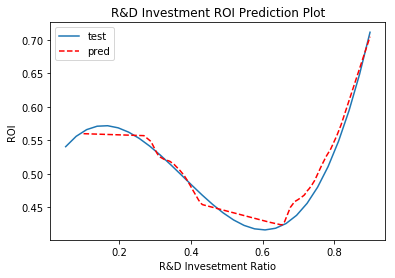

In [33]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_xs,pred_ys,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

<br>

## 4. Dropout의 기술적 특징
---

1. Dropout은 일종의 앙상블 기법으로 설명하기도 합니다.<br>
    앙상블이란, 복수 개의 모델을 같이 이용해 결과를 계산하는 기법을 통칭합니다.<br>
    Dropout은 일부 뉴런들을 꺼줌으로써, 부분 신경망(SubNetwork)를 구성하는 효과를 가집니다.<br>
    
2. Dropout은 한 유닛이 특정 input에만 의존하지 못하도록 만듭니다.<br>
   모든 input 유닛 값에 주의를 기울이게 되므로, 입력 값의 작은 변화에 덜 민감해집니다.

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---